# Projet HDDL : DeepMoji

5GMM - Emma Espinasse, Elizabeth Fu, Paul Larousse, Wilhelm Støren (19/01/2021)

### What is Deepmoji ?

The idea behind Deepmoji is that in many cases, emojis serve as a proxy for the emotional contents of a text. Deepmoji is an available pre-trained model that can be used for different target tasks.

It was pretrained on the classification task of predicting which emoji were initially part of a text. It gives the top 5 most likely emojis for the text, as well as the probability for each suggested emoji. The study of the authors showed that this pretraining helped to have a better prediction for the target task. In this notebook, we will also see it that statement is true.

### Requirements
- Python 2.7 with pip
- Theano (0.9+) or Tensorflow (1.3+)
- Keras
- scikit-learn
- h5py
- text-unidecode
- emoji

# Model architecture
---
The model is based on the LSTM (Long-Short Term Memory) model that has been successful at many NLP tasks.

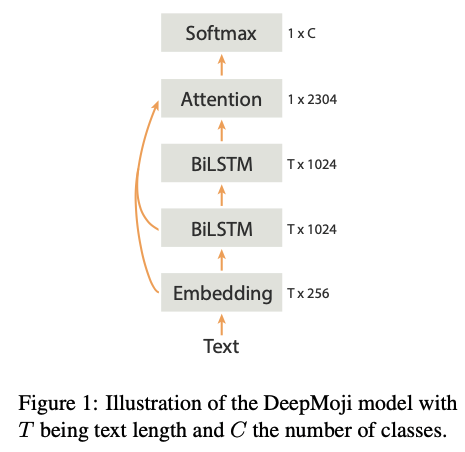

- (INPUT LAYER) embedding layer
    - 256 dimensions
    - to project each word into a vector space
    - activation function: tanh -> to constraint each embedding dimension within [-1,1]
    
- bidirectional LSTM layer
    - 1024 hidden layers (512 in each direction)
    
- bidirectional LSTM layer
    - 1024 hidden layers (512 in each direction)
    
- attention layer
    - takes all previous layers as input using skip-connections
    - lets the model decide the importance of each word for the prediction task by weighing them
    - output: representation vector $v$ (high level encoding of the entire text)

- (OUTPUT LAYER) softmax layer
    - for classification (here a multi-classification problem with C classes)

DeepMoji focuses on 64 emojis only. $C = 64$

## LSTM

Long-short term memory (LSTM) is a specific type of recurrent neural networks (RNN), and is very common in NLP as it is specialised in processing sequential data. In contrast to normal neural networks, in RNN the output is fed back through the network allowing the information passing through the network to persist. This enables RNN to connect previous information to the present task. A LSTM takes this further and can "remember" information for longer periods which is an advantage in NLP. 
LSTM contains different gates and cells: 
* **Memory cell**: "stores" the information running through the unit (from previous time steps).
* **Input gate**: decides which values and to update and their candidate values, and thus controls the new information included in the memory cell.
* **Forget gate**: discard information that is considered unnecessary.
* **Output gate**: the output to the rest of the network based on the memory cell and the two gates above.

In text information does not only read one way, ie. from left to right, which is why the model consideres bidirectional LSTMs.

## Attention layer 

__Definition:__ In the current language, attention is the process of focusing only on one or a few things. 

_For example, when we want to count the number of people in a classroom, we only focus on the number of head, we don't need to take the entire body into account._

__The attention layer__ has the same objective. In a sentence, it aims to detect the words that bring the most knowledge. In our case, we want to understand the feeling given off by a sentence. Words such as 'beautiful', 'amazing' or 'bad' will therefore bring a lot of information on the emotionnal meaning of the sentence. 

__Mathematically__ this mechanism, introduced by Bahdanau and al. in 2015, is quite simple. 

When the attention layer constructs the representation of the text, it attributes weights $w_a$ to each word. If we note $h_t$ the representation of the $t^{th}$ word of the sentence, we have:
$$e_t = h_tw_a$$
$e_t$ is here the weighted representation of the word $h_t$.

Using a softmax function, we find the attention importance score $\alpha_i$ of the word:
$$\alpha_i = \frac{exp(e_t)}{\sum_{i=0}^T exp(e_i)}$$
This value $\alpha$ is a probability distribution over the words of a sentence.

To be able to class the sentence, it needs to be reconstructed. A simple sum is needed:
$$v = \sum_{i=1}^T \alpha_i h_i$$
The vector $v$ is called a representation vector and is a high-level encoding of the entire sentence. It is also the input vector of the final softmax layer for classification.

Actually, the attention mechanism, coupled with the skip-connections are used to ease the transfer learning for further target tasks, that we will explain later. 

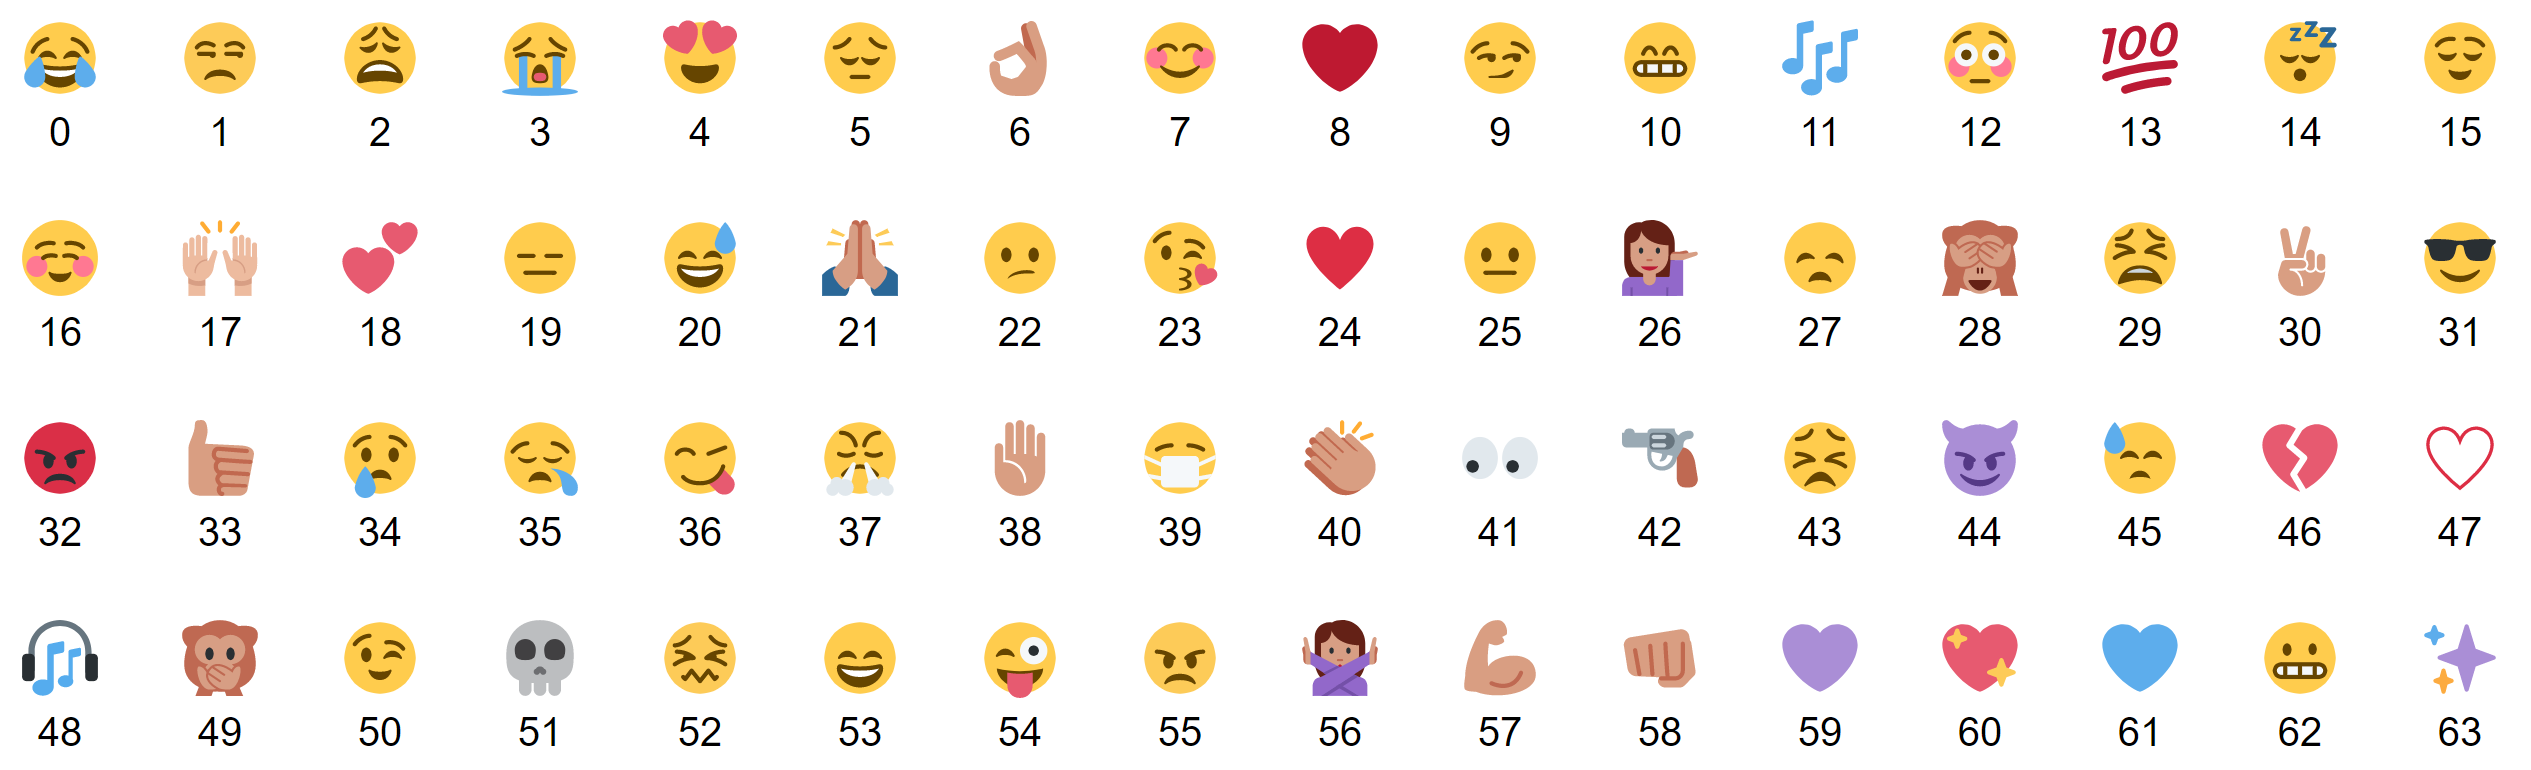
_List of the 64 most common emoji_

# Application of DeepMoji
---

DeepMoji gives the top 5 most likely emojis for a given text, as well as the probability for each suggested emoji.

* **Dataset** :
1.246 billion tweets containing one of the given 64 common emojis.
Each tweet can contain multiple emojis. A single tweet is stored for each unique emoji.
-> 1.6 billion tweets

* **Test set** : 640K tweets (10K of each emoji type)

* **Validation set** : 640K tweets (10K of each emoji type)

* **Training set** : remaining tweets + upsampling

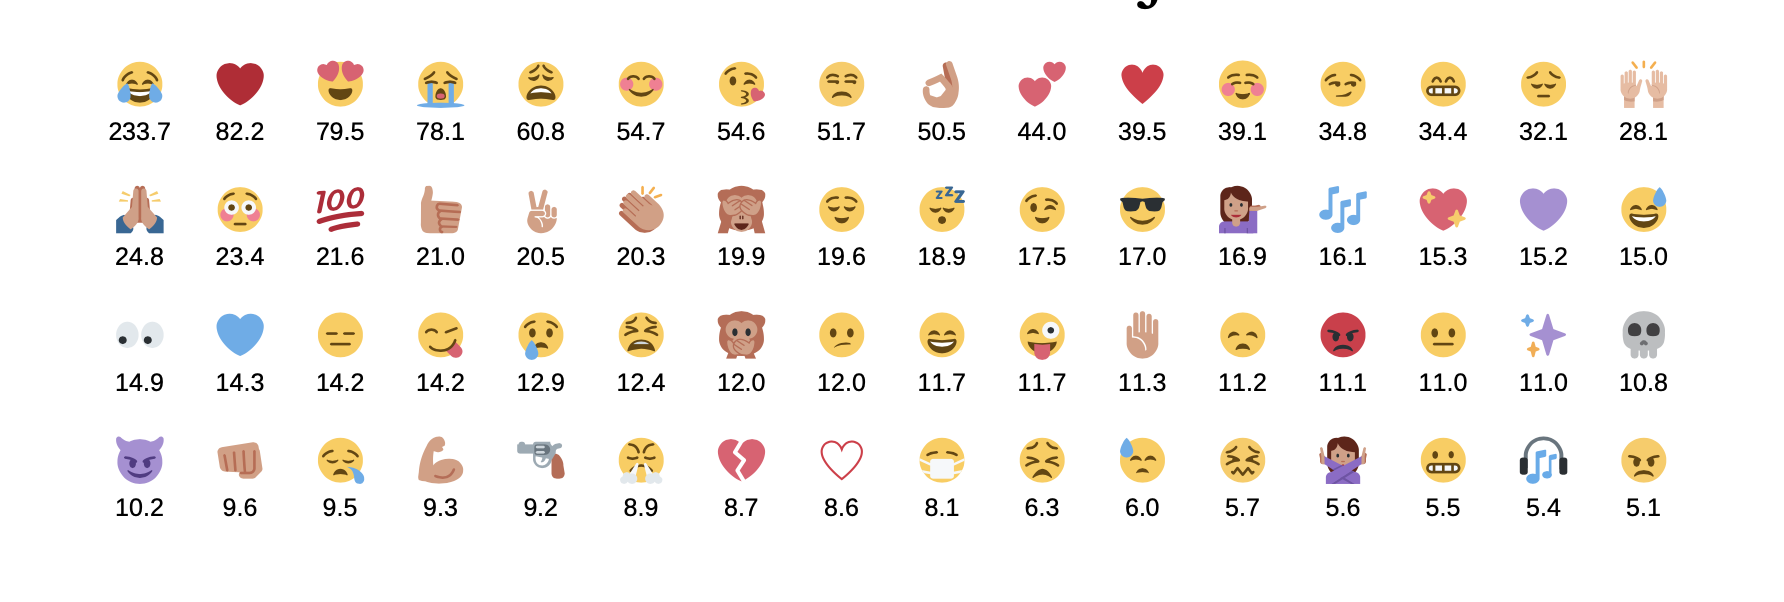

_Number of tweets in the dataset associated with each emoji (in millions)_

In [8]:
from __future__ import print_function, division
#import example_helper
import json
import csv
import numpy as np
from deepmoji.sentence_tokenizer import SentenceTokenizer
from deepmoji.model_def import deepmoji_emojis
from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

OUTPUT_PATH = 'test_sentences.csv'

TEST_SENTENCES = [u'I feel sick.', #normal sentences
                  u'I loved that movie!',
                  u'I love how you never reply back..', # irony and sarcasm
                  u'He is never happy for me, he is such a good friend...',
                  u'This is shit', # comparison between slang and not slang
                  u'This is the shit',
                  u'I can\'t wait for corona to go away'] # test for a new word

def top_elements(array, k):
    ind = np.argpartition(array, -k)[-k:]
    return ind[np.argsort(array[ind])][::-1]

maxlen = 30
batch_size = 32

print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)
st = SentenceTokenizer(vocabulary, maxlen)
tokenized, _, _ = st.tokenize_sentences(TEST_SENTENCES)

print('Loading model from {}.'.format(PRETRAINED_PATH))
model = deepmoji_emojis(maxlen, PRETRAINED_PATH)
model.summary()

Tokenizing using dictionary from /Users/efu/Documents/INSA/INSA-5A/HDDL/projet/HDDL_moji/model/vocabulary.json
Loading model from /Users/efu/Documents/INSA/INSA-5A/HDDL/projet/HDDL_moji/model/deepmoji_weights.hdf5.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      12800000    input_5[0][0]                    
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 30, 256)      0           embedding[0][0]                  
____________________________________________________________________________________________

In [9]:
print('Running predictions.')
prob = model.predict(tokenized)

# Find top emojis for each sentence. Emoji ids (0-63)
# correspond to the mapping in emoji_overview.png
# at the root of the DeepMoji repo.
print('Writing results to {}'.format(OUTPUT_PATH))
scores = []
for i, t in enumerate(TEST_SENTENCES):
    t_tokens = tokenized[i]
    t_score = [t]
    t_prob = prob[i]
    ind_top = top_elements(t_prob, 5)
    t_score.append(sum(t_prob[ind_top]))
    t_score.extend(ind_top)
    t_score.extend([t_prob[ind] for ind in ind_top])
    scores.append(t_score)
    print(t_score)

with open(OUTPUT_PATH, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator='\n')
    writer.writerow(['Text', 'Top5%',
                     'Emoji_1', 'Emoji_2', 'Emoji_3', 'Emoji_4', 'Emoji_5',
                     'Pct_1', 'Pct_2', 'Pct_3', 'Pct_4', 'Pct_5'])
    for i, row in enumerate(scores):
        try:
            writer.writerow(row)
        except Exception:
            print("Exception at row {}!".format(i))

Running predictions.
Writing results to test_sentences.csv
[u'I feel sick.', 0.78815985471010208, 39, 52, 43, 27, 45, 0.53702104, 0.096464679, 0.06454844, 0.051482383, 0.038643312]
[u'I loved that movie!', 0.2878316193819046, 4, 16, 8, 6, 40, 0.08005859, 0.055426072, 0.053529911, 0.05083669, 0.047980357]
[u'I love how you never reply back..', 0.39060431718826294, 1, 19, 55, 25, 46, 0.13978004, 0.082515739, 0.062788285, 0.054191161, 0.051329087]
[u'He is never happy for me, he is such a good friend...', 0.61038759350776672, 46, 5, 34, 27, 35, 0.2167147, 0.12788892, 0.11282174, 0.10254616, 0.050416082]
[u'This is shit', 0.31180431321263313, 55, 32, 27, 1, 37, 0.070093207, 0.063969426, 0.060115729, 0.059525676, 0.058100276]
[u'This is the shit', 0.37477060779929161, 48, 11, 6, 31, 9, 0.10890723, 0.096594594, 0.064820789, 0.056501403, 0.047946591]
[u"I can't wait for corona to go away", 0.27680433914065361, 17, 2, 10, 29, 62, 0.059332285, 0.057746291, 0.055291809, 0.054247018, 0.050186936]

# Finetuning for further target tasks
---
We can use DeepMoji for a further target task.

To do so, the architecture of Deepmoji is used as a base, and we need to adapt the architecture slightly to correspond to the new target task. Most often, only the final softmax layer is changed. For example, in Deepmoji, the softmax layer contains 64 classes as the pretraining task was a classification multi-class.

Now if the new target task is to detect if a given text is positive of negative, it can be reprensented as a binary classification problem, and the softmax layer will only have one neuron.

Depending on the problem, we can also add layers within the original DeepMoji arhitecture, such as dropout layers.

The modified architecture will be fine-tuned on the supplementary dataset. Because Deepmoji is a pretrained model, the information already learned will be used during the fine-tuning for the new target task. We talk about "transfer learning" of the model.

## Transfer learning
It is the term used when a pretrained model is used for a different target task.
We will present three approches for the transfer learning: the last approach, the full approach and the 'chain-thaw' approach. The first two are common methods, the last one was created by the authors of DeepMoji. 

### 'last approach'
_Principle:_ all layers of the model are frozen when fine-tuning on the target task, except the last layer.

In our case, this means that we will remove the last softmax layer. The output of our model will be the features of the sentences, and should then give information for a task other than the initial one.
<img src="attachment:feature_extractor.PNG" width="400">

### 'full approach'
_Principle:_ the full model is unfrozen and we take the pretrained model as an intialization for the target task.

### Chain-thaw
In 2017, the creators of the DeepMoji algorithms, proposed a new simple transfer learning approach called __"chain-thaw"__. 

This new transfer learning approach works on training layers one by one on the new data. When a certain layer is trained, we say that it is 'unfreezed'. The other layers are therefore 'freezed'. The latter means that we keep the weights already calculated.

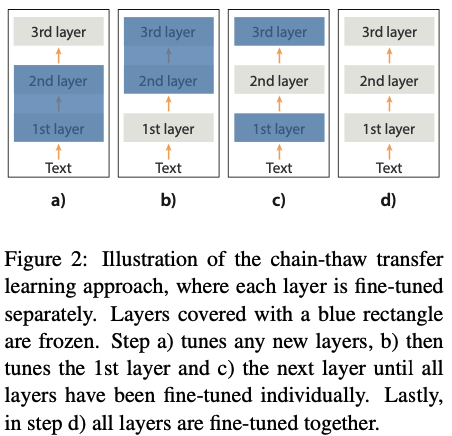

The process is done in a specific order. And in this method, the optimizer if 'Adam'.

0) all new layers are fine-tuned, generally, only the final softmax layer has been changed, so we jump onto the next step.

1) _defreeze the last layer_ : This corresponds to the 'last approach'. If we consider a 3-layers network, the first and the second layer still have the weights obtained by training the layers on the emojis data. The third layer (the classification layer) is unfreezed and is trained for the new task.

2) _defreeze the other layers one by one_ starting with the first. 

3) _defreeze all the layers_ and train the entire network for the new task.

The "chain-thaw" method may seem a bit cumbersome but in reality the time needed for fine-tuning is limited if the new target task uses small datasets. 

### Application of the transfer learning: detecting insults in social commentary
Let's use the DeepMoji algorithm for the kaggle challenge "Detecting Insults in Social Commentary". The challenge was to predict whether a comment posted during a public discussion is considered insulting to one of the participants. (reference : https://www.kaggle.com/c/detecting-insults-in-social-commentary/data)

The data has 2 attributes:
- date: time at which the comment was made (sometimes blank)
- comment: unicode-escaped text of the content, surrounded by double-quotes (mostly english)

Each comment has been given a label:
- 0 for a neutral comment
- 1 for an insulting comment

This is a single class (binary) classification problem.

The dataset has been divided in 2 :
- training dataset: 3947 comments (2898 neutral + 1089 insults) with labels for all comments (supervised learning)
- test dataset: 2235 comments (1158 neutral + 1077 insults)

It is said that this problem tends to strongly overfit.

In [12]:
import pandas as pd

df_train = pd.read_csv("data/train.csv")
df_test  = pd.read_csv("data/test.csv")

print(df_train.shape, df_test.shape)

(3947, 3) (2235, 3)


In [13]:
from deepmoji.model_def import deepmoji_transfer
from deepmoji.finetuning import (
    load_benchmark,
    finetune)

DATASET_PATH = 'data/kaggle-insults/raw.pickle'
nb_classes = 2 # binary classification

with open('model/vocabulary.json', 'r') as f:
    vocab = json.load(f)
print("lets go")
# Load dataset. Extend the existing vocabulary with up to 10000 tokens from
# the training dataset.
print("loading benchmark")
data = load_benchmark(DATASET_PATH, vocab, extend_with=10000)
print("finished")

# Set up model and finetune. Note that we have to extend the embedding layer
# with the number of tokens added to the vocabulary.
model2 = deepmoji_transfer(nb_classes, data['maxlen'], PRETRAINED_PATH,
                          extend_embedding=data['added'])
model2.summary()

old_weights = model2.get_weights()

lets go
loading benchmark
finished
Loading weights for embedding
Extended vocabulary for embedding layer from 50000 to 53545 tokens.
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      13707520    input_6[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 50, 256)      0           embedding[0][0]                  
________________________________________________________

Changes made to the original DeepMoji model :

The finetuning process developped by the authors of Deepmoji is set as such:
- learning rate is set to 1e-3 for training of all new layers, set to 1e-4 for fine-tuning of any pretrained layers (of the initial DeepMoji architecture)
- We add a dropout process on the embedding layer to prevent overfitting on small datasets (dataset of the new task), dropout is fixed at 10% : "embed_drop" (SpatialDropout1D layer)
- We add a Dropout layer "dropout_1" used to limit the overall overfitting. In this case, it is a good choice as the kaggle challenge warned that the problem was prone to strongly overfit.

The final softmax layer is also changed for only one neuron -> because here for a given comment, the prediction is 0 or 1 (neutral or insult).

In [11]:
model2, acc = finetune(model, data['texts'], data['labels'], nb_classes,
                      data['batch_size'], method='chain-thaw')
print('Acc: {}'.format(acc))

NameError: name 'finetune' is not defined

We trained the model in a separate notebook. It took approximately 1h on a GMM computer with GPU and 2h30 on a computer with CPU.

We get this output:

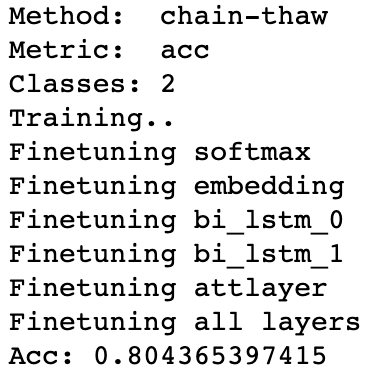

In [14]:
from deepmoji.model_def import load_specific_weights
load_specific_weights(model2, weight_path='/Users/efu/Downloads/model_weight.h5')

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Loading weights for softmax


### Analyzing the effect of pretraining

In the article, the authors suggest that the pretraining is an important step. They compared the performance of Deepmoji without pretraining on a target task, and Deepmoji pretrained + fine-tuning on the same target task.
For different target tasks, they got that the pretrained model had a better accuracy.

In our case, we can easily sense that if we implement Deepmoji without pretraining for the target task of the Kaggle insults, the model will be overfitted. Indeed, we have approx. 32 millions paramters, for only 3 000 comments (neutral and insults).

So, we can make the assumption that the authors' statement is true.

### Now, let's try to implement a simplified algorithm for the target task


In [2]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import numpy as np
import matplotlib.pyplot as plt

/Applications/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:283: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
# data
df_train = pd.read_csv("data/train.csv")
df_test  = pd.read_csv("data/test.csv")

texts_train = df_train["Comment"]
texts_test  = df_test["Comment"]
y_train = df_train["Insult"].values

In [4]:
maxlen = 50
vocab_size = 2000
glove_path = "glove/glove.twitter.27B."
embed_dim = 50

In [5]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(texts_train))
tokenized_train = tokenizer.texts_to_sequences(texts_train)
tokenized_test = tokenizer.texts_to_sequences(texts_test)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [7]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(glove_path+str(embed_dim)+'d.txt'))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
# network

lstm_nodes = 32

inp = Input(shape = (maxlen,))
x = Embedding(nb_words, embed_dim, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(lstm_nodes, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(lstm_nodes, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(1, activation = "sigmoid")(x)
model = Model(inputs=inp, outputs=x, name = "lstm")
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 64)            21248     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 64)            24832     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 146,145
Trainable params: 146,145
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train,batch_size=16, epochs=15, verbose = 2, validation_split=0.15);

Train on 3354 samples, validate on 593 samples
Epoch 1/15
 - 26s - loss: 0.5691 - acc: 0.7233 - val_loss: 0.4846 - val_acc: 0.7352
Epoch 2/15
 - 25s - loss: 0.4566 - acc: 0.7874 - val_loss: 0.4194 - val_acc: 0.8246
Epoch 3/15
 - 26s - loss: 0.3808 - acc: 0.8351 - val_loss: 0.3775 - val_acc: 0.8432
Epoch 4/15
 - 26s - loss: 0.3449 - acc: 0.8518 - val_loss: 0.3620 - val_acc: 0.8516
Epoch 5/15
 - 26s - loss: 0.3152 - acc: 0.8673 - val_loss: 0.3675 - val_acc: 0.8516
Epoch 6/15
 - 25s - loss: 0.3022 - acc: 0.8739 - val_loss: 0.3697 - val_acc: 0.8583
Epoch 7/15
 - 25s - loss: 0.2763 - acc: 0.8831 - val_loss: 0.3792 - val_acc: 0.8567
Epoch 8/15
 - 28s - loss: 0.2559 - acc: 0.8998 - val_loss: 0.3968 - val_acc: 0.8482
Epoch 9/15
 - 27s - loss: 0.2437 - acc: 0.9007 - val_loss: 0.4154 - val_acc: 0.8499
Epoch 10/15
 - 26s - loss: 0.2303 - acc: 0.9091 - val_loss: 0.4198 - val_acc: 0.8432
Epoch 11/15
 - 26s - loss: 0.2140 - acc: 0.9189 - val_loss: 0.4257 - val_acc: 0.8533
Epoch 12/15
 - 26s - loss: 

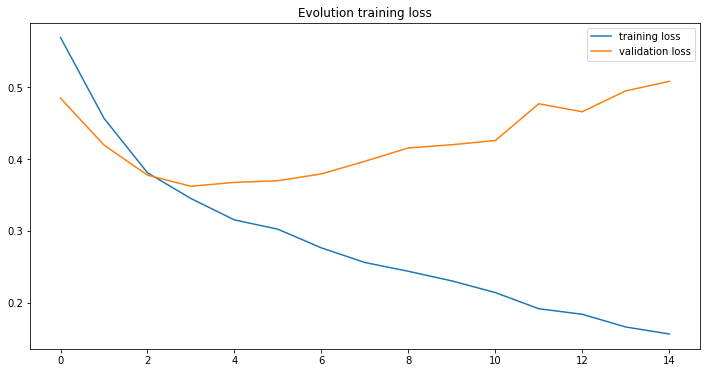

In [10]:
plt.figure(figsize=(12,6))
plt.title("Evolution training loss")
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

We can see that the validation loss increases strating from the 3rd epoch.

In [11]:
y_predict = model.predict([X_test], batch_size=1024, verbose=1)
y_pred = np.zeros_like(y_predict)
y_pred[y_predict > 0.5] = 1
df_test["Insult"] = y_pred
df_test.values[-10]
def show_insult(df_insults, ind_insult):
    print("COMMENT: {0} ----- PREDICTION: {1}".format(df_insults["Comment"][ind_insult], int(df_insults["Insult"][ind_insult])))

2235/2235 [==============================] - 1s 312us/step


In [12]:
show_insult(df_test, 2225)
show_insult(df_test, 424)
show_insult(df_test, 1445)
show_insult(df_test, 828)
show_insult(df_test, 2139)

COMMENT: "Fuck yOu Not working mother fucker!! Eat My Dick your mother is a bitch" ----- PREDICTION: 1
COMMENT: "Dude, you are sick bro. " ----- PREDICTION: 1
COMMENT: "great photos ashley!! you are so talented! " ----- PREDICTION: 0
COMMENT: "\xa0Why did your parents wish you were adopted ?" ----- PREDICTION: 1
COMMENT: "are you kidding me" ----- PREDICTION: 0


## Limits of the Deepmoji algorithm

Some limits or issues related to the algorithm were stated by the authors themselves :
- "For some sentences it can be difficult for the model to see if the text is being ironic or not. In those cases, the most likely emojis are either very positive or very negative."
- "the model has learned about language from the raw, uncurated expressions of individuals on social media. We do not endorse in any way the emotional interpretation that the model has of any particular content."

## References

Paper https://arxiv.org/abs/1708.00524

Blog post https://medium.com/@bjarkefelbo/what-can-we-learn-from-emojis-6beb165a5ea0

Website https://deepmoji.mit.edu/

Code https://github.com/bfelbo/DeepMoji